# Projeto Segmentação de Consumidores em um E-Commerce

O objetivo principal deste projeto é identificar e segmentar os consumidores de uma loja online de utensílios domésticos, chamada "Everything Plus", com base em seus perfis de compra. A segmentação de consumidores é uma estratégia fundamental para personalizar ofertas, estratégias de marketing e melhorar a experiência do cliente.

Dessa forma podemos personalizar ofertas, aprimorar a retenção de clientes e melhorar a experiência do cliente.

# Inicializando

Vamos carregar as bibliotecas necessárias para nosso projeto.

In [ ]:
# Importando as bibliotecas
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carregando os dados

**Descrição dos Dados**

Estamos analizando o histórico de transações da ***Everything Plus***, uma loja online que vende utensílios domésticos.

O arquivo contém as seguintes colunas:

`InvoiceNo` — identificador de pedido

`StockCode` — identificador de item

`Description` — nome de item

`Quantity`

`InvoiceDate` — data do pedido

`UnitPrice` — preço por item

`CustomerID`

Vamos armazenar os dados em variáveis específicas e, em seguida, otimizá-los para a análise, certificando-nos de que cada coluna contenha o tipo correto de dados.

In [ ]:
# Carregando os dados
transactions = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep = '\t')

In [ ]:
# Analizando informações detalhadas do dataframe
transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 157.9 MB


## Pré-processamento

- Vamos processar os dados fazendo as devidas correções.

In [ ]:
# Renomeando as colunas para seguir o padrão snake_case
transactions.rename(columns={
    'InvoiceNo': 'invoice_no',
    'StockCode': 'stock_code',
    'Description': 'description',
    'Quantity': 'quantity',
    'InvoiceDate': 'invoice_date',
    'UnitPrice': 'unit_price',
    'CustomerID': 'customer_id'
}, inplace=True)

In [ ]:
# Corrigindo tipo de dado
transactions['invoice_date'] = pd.to_datetime(transactions['invoice_date'])

In [ ]:
# Verificando se a conversão funcionou
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


In [ ]:
# Visualizando fatia do dataframe após correções
transactions.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0


Verificando valores ausentes e duplicados

In [ ]:
# Verificando os duplicados
transactions.duplicated().sum()

5268

In [ ]:
# Processando os valores duplicados
transactions = transactions.drop_duplicates()

In [ ]:
# Verificando valores ausentes
transactions.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135037
dtype: int64

In [ ]:
# Analizando só os ausentes da coluna 'customer_ID'
transactions[transactions['customer_id'].isnull()]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.00,NaN
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2018-11-29 14:32:00,2.51,NaN
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2018-11-29 14:32:00,2.51,NaN
1445,536544,21786,POLKADOT RAIN HAT,4,2018-11-29 14:32:00,0.85,NaN
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2018-11-29 14:32:00,1.66,NaN
...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2019-12-07 10:26:00,4.13,NaN
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2019-12-07 10:26:00,4.13,NaN
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2019-12-07 10:26:00,4.96,NaN
541539,581498,85174,S/4 CACTI CANDLES,1,2019-12-07 10:26:00,10.79,NaN


- Para a coluna `description`, podemos preencher os valores ausentes com um rótulo como "No description available". Essa coluna se refere ao nome do item.

- Para a coluna `customer_ID`, podemos preecher com um valor específico que indique que esses registros não estão associados a nenhum cliente identificado.

In [ ]:
# Preenchendo valores ausentes na coluna 'description'
transactions['description'].fillna('No description available', inplace=True)

Podemos preencher os valores ausentes na coluna `customer_ID` com um valor que não seja usado por clientes reais pois queremos manter esses registros, mas precisamos sinalizar claramente que os IDs de clientes estão ausentes.
Escolhemos valor 1 para representar esses clientes.

In [ ]:
# Substituindo valores ausentes
transactions['customer_id'].fillna(1, inplace=True)

In [ ]:
# Verificando após processar os valores ausentes
transactions.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
dtype: int64

In [ ]:
# Analizando os dados após as correções
transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    536641 non-null  object        
 1   stock_code    536641 non-null  object        
 2   description   536641 non-null  object        
 3   quantity      536641 non-null  int64         
 4   invoice_date  536641 non-null  datetime64[ns]
 5   unit_price    536641 non-null  float64       
 6   customer_id   536641 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 127.3 MB


- Encontramos valores negativos na coluna `quantity`e `unit_price` de um conjunto de dados de transações, porém a quantidade de itens e o preço do item não pode ser negativa. Esses valores negativos podem ser erros nos dados. Vamos transformar esses valores negativos em positivos nas colunas 'quantity' e 'unit_price'.

In [ ]:
# Analizando valores negativos da coluna 'quantity'
transactions[transactions['quantity'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2019-12-07 09:57:00,0.83,14397.0
541541,C581499,M,Manual,-1,2019-12-07 10:28:00,224.69,15498.0
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2019-12-07 11:57:00,10.95,15311.0
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2019-12-07 11:58:00,1.25,17315.0


In [ ]:
# Analizando valores negativos da coluna 'unit_price'
transactions[transactions['unit_price'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,1.0
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,1.0


In [ ]:
# Transformar os valores negativos em positivos
transactions['quantity'] = transactions['quantity'].abs()
transactions['unit_price'] = transactions['unit_price'].abs()

- Com os dados processados, otimizados e tipos corretamente ajustados, estamos prontos para iniciar algumas análises exploratórias.

- Vamos fazer boxplots das colunas de única variável contínua para analisarmos se há presença de outliers que possam interferir na análise.

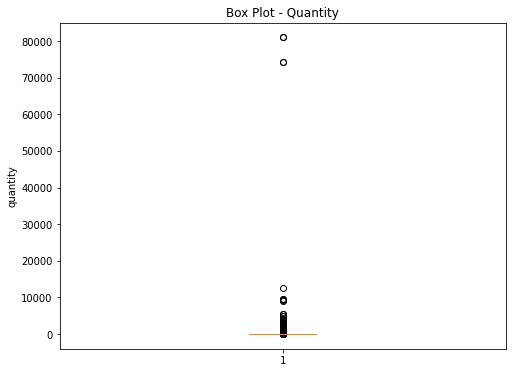

In [ ]:
# Boxplot para a coluna 'quantity'
plt.figure(figsize=(8, 6))
plt.boxplot(transactions['quantity'])
plt.title('Box Plot - Quantity')
plt.ylabel('quantity')
plt.show()

- O gráfico acima representa a distribuição da coluna `quantity` com informações que nos ajudam a analisar  outliers, que são valores discrepantes, identificados como pontos acima ou abaixo da linha em laranja.
- O boxplot dessa coluna revela a presença de outliers, indicando transações com quantidades muito diferentes da maioria.

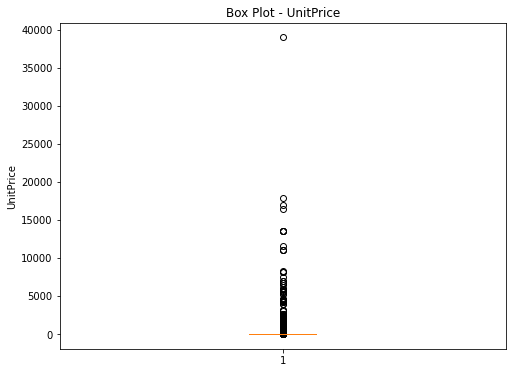

In [ ]:
# Boxplot para a coluna 'unit_price'
plt.figure(figsize=(8, 6))
plt.boxplot(transactions['unit_price'])
plt.title('Box Plot - UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

- O gráfico acima representa a distribuição da coluna `unit_price` no conjunto de dados.
No boxplot dessa coluna também observamos a presença de outliers, indicando a existência de itens com preços muito diferentes da maioria dos produtos.

Em resumo, os gráficos boxplot fornecem informações valiosas sobre a distribuição e a presença de outliers nas colunas 'quantity' e 'unit_price'. A análise desses gráficos pode ser útil para identificar transações ou clientes atípicos no conjunto de dados.

- Vamos calcular os intervalos IQR e limites para essas colunas e em seguida remover os outliers para melhor análise.

In [ ]:
# Calculando o IQR para 'unit_price'
Q1_unit_price = transactions['unit_price'].quantile(0.25)
Q3_unit_price = transactions['unit_price'].quantile(0.75)
IQR_unit_price = Q3_unit_price - Q1_unit_price

In [ ]:
# Definindo limites para 'unit_price'
limite_inferior_unit_price = Q1_unit_price - 1.5 * IQR_unit_price
limite_superior_unit_price = Q3_unit_price + 1.5 * IQR_unit_price

In [ ]:
# Calculando o IQR para 'quantity'
Q1_quantity = transactions['quantity'].quantile(0.25)
Q3_quantity = transactions['quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

In [ ]:
# Definindo os limites para 'quantity'
limite_inferior_quantity = Q1_quantity - 1.5 * IQR_quantity
limite_superior_quantity = Q3_quantity + 1.5 * IQR_quantity

In [ ]:
# Removendo os outliers em ambas as colunas
transactions_sem_outliers = transactions[
    (transactions['unit_price'] >= limite_inferior_unit_price) & (transactions['unit_price'] <= limite_superior_unit_price) &
    (transactions['quantity'] >= limite_inferior_quantity) & (transactions['quantity'] <= limite_superior_quantity)
]

In [ ]:
# Visualizando fatia do novo dataframe
transactions_sem_outliers

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680.0


In [ ]:
# Analisando a porcentagem de outliers
tamanho_original = len(transactions)
tamanho_sem_outliers = len(transactions_sem_outliers)

In [ ]:
porcentagem_outliers = ((tamanho_original - tamanho_sem_outliers) / tamanho_original) * 100
porcentagem_outliers

12.623150299734831

**Total de compras individuais**

- Vamos calcular os totais de compras individuais multiplicando a coluna `quantity` pela `unity_price`. Em seguida, criaremos um histograma desses totais de compra para visualizar a distribuição dos valores.

In [ ]:
# Calculando os totais de compras individuais (quantity x unit price)
pd.options.mode.chained_assignment = None
transactions_sem_outliers['total_de_compra'] = transactions_sem_outliers['quantity'] * transactions_sem_outliers['unit_price']

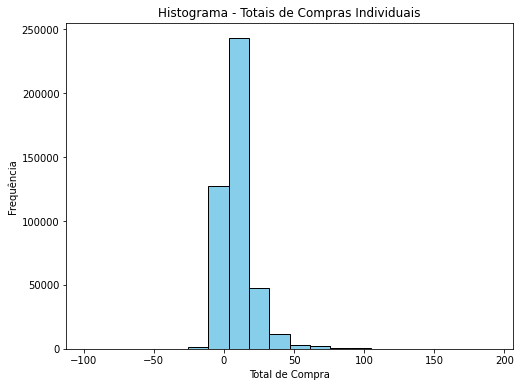

In [ ]:
# Criando o histograma
plt.figure(figsize=(8, 6))
plt.hist(transactions_sem_outliers['total_de_compra'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma - Totais de Compras Individuais')
plt.xlabel('Total de Compra')
plt.ylabel('Frequência')
plt.show()

- O histograma acima exibe a distribuição dos totais de compras individuais, resultantes da multiplicação da quantidade pelo preço unitário. A maioria das compras tem valores baixos, mas algumas transações são de alto valor, criando uma barra mais longa. Isso indica que a maioria das transações envolve itens baratos, mas há compras significativamente caras.

In [ ]:
# Agrupando as transações por dia e calculando o total de compras
total_compras_por_dia = transactions_sem_outliers.groupby(transactions_sem_outliers['invoice_date'].dt.date)['unit_price'].sum()

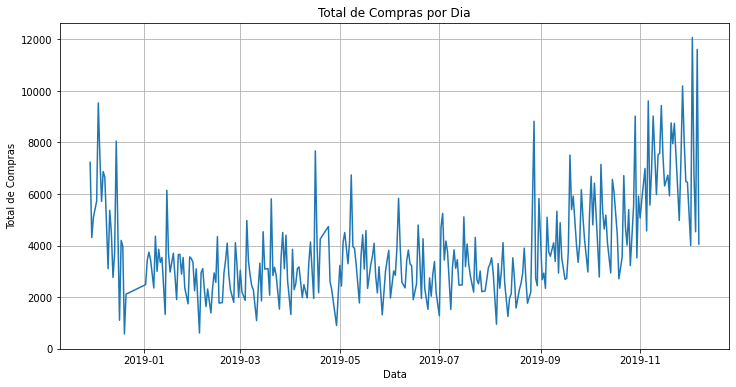

In [ ]:
# Criando um gráfico de linha para mostrar o total de compras por dia
plt.figure(figsize=(12, 6))
total_compras_por_dia.plot()
plt.title('Total de Compras por Dia')
plt.xlabel('Data')
plt.ylabel('Total de Compras')
plt.grid(True)
plt.show()

- Este gráfico de linha mostra o total de compras feitas por dia. Para criar este gráfico, agrupamos as transações por dia e calculamos a soma dos preços unitários dessas transações. O eixo x representa as datas, enquanto o eixo y mostra o total de compras para cada dia. O gráfico revela tendências ao longo do tempo, como variações nos valores de compra em diferentes datas. Também ajuda a identificar os picos de compras (Observado em novembro de 2019) e as tendências sazonais, fornecendo informações úteis sobre o comportamento dos clientes em relação às compras ao longo do tempo.

**Top 10 produtos mais vendidos**

In [ ]:
# Contando o número de vendas para cada produto
vendas_por_produto = transactions_sem_outliers['description'].value_counts().head(10)

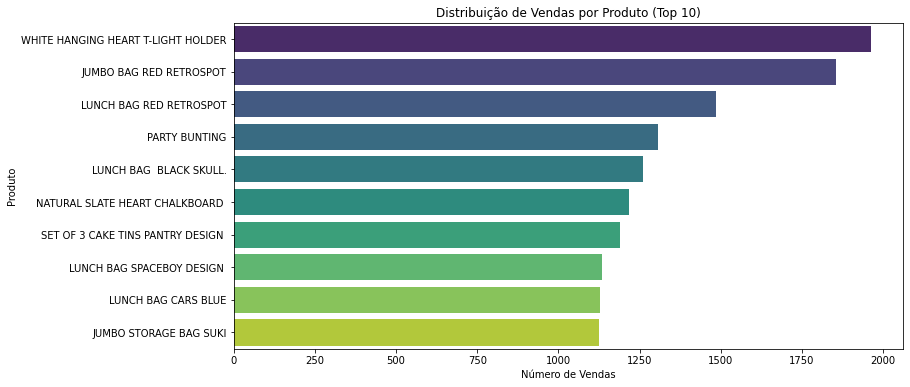

In [ ]:
# Criando gráfico de barras com Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=vendas_por_produto.values, y=vendas_por_produto.index, palette='viridis')
plt.title('Distribuição de Vendas por Produto (Top 10)')
plt.xlabel('Número de Vendas')
plt.ylabel('Produto')
plt.show()

- Este gráfico de barras representa a distribuição das vendas dos produtos mais populares, exibindo os 10 produtos com mais vendas. Cada barra no gráfico representa um produto específico, e a altura da barra indica o número de vendas desse produto. Os produtos estão listados no eixo y, enquanto o eixo x representa o número de vendas. O gráfico ajuda a identificar os produtos mais vendidos e fornece insights sobre os produtos preferidos pelos clientes.

## Segmente os usuários com base no histórico de compras

### Vamos conduzir uma análise de compras calculando RFM

Três métricas essenciais: Recência, Frequência e Valor Monetário (RFM). O RFM nos fornece insights valiosos sobre o comportamento de compra dos clientes. A métrica **Recência** reflete o tempo decorrido desde a última compra de um cliente, **Frequência** indica com que frequência um cliente faz compras e **Valor Monetário** representa o montante total gasto por cada cliente em suas compras.

Agora que temos essas métricas RFM, podemos usá-las para segmentar os clientes com base em seus padrões de compra. Essa segmentação nos permitirá desenvolver estratégias de marketing personalizadas para cada segmento, atendendo melhor às necessidades e preferências individuais de nossos clientes.

In [ ]:
# Criando uma tabela de RFM por cliente
rfm_table = transactions_sem_outliers.groupby('customer_id').agg({
    'invoice_date': lambda x: (x.max() - x.min()).days,  # Recência
    'invoice_no': 'count',  # Frequência
    'unit_price': 'sum'  # Valor Monetário
})

In [ ]:
# Renomeando as colunas
rfm_table.rename(columns={
    'invoice_date': 'recency',
    'invoice_no': 'frequency',
    'unit_price': 'monetary_value'
}, inplace=True)

In [ ]:
# Exibindo a tabela RFM
rfm_table

,recency,frequency,monetary_value
customer_id,,,
1.0,372,117240,373009.82
12347.0,365,167,398.08
12348.0,109,6,3.90
12349.0,0,64,200.75
12350.0,0,16,25.30
...,...,...,...
18280.0,0,9,37.70
18281.0,0,5,5.46
18282.0,118,9,24.14


### Vamos prosseguir com a segmentação de clientes usando o algoritmo de clustering K-Means.

O K-Means é uma técnica de agrupamento que divide os clientes em clusters com base em suas métricas de Recência, Frequência e Valor Monetário (RFM).

In [ ]:
# Escolhendo o número de clusters (segmentos) desejado
numero_de_clusters = 4

In [ ]:
# Padronizando as métricas RFM para que tenham a mesma importância
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_table)

In [ ]:
# Criando o modelo K-Means com o número de clusters escolhido
kmeans = KMeans(n_clusters=numero_de_clusters, random_state=0)
kmeans.fit(rfm_scaled)

KMeans(n_clusters=4, random_state=0)

In [ ]:
# Adicionando a coluna 'segment' com os rótulos de cluster ao DataFrame RFM
rfm_table['segment'] = kmeans.labels_

In [ ]:
# Exibindo a tabela RFM com os rótulos de segmento
rfm_table

,recency,frequency,monetary_value,segment
customer_id,,,,
1.0,372,117240,373009.82,2
12347.0,365,167,398.08,0
12348.0,109,6,3.90,3
12349.0,0,64,200.75,1
12350.0,0,16,25.30,1
...,...,...,...,...
18280.0,0,9,37.70,1
18281.0,0,5,5.46,1
18282.0,118,9,24.14,3


- Vamos calcular as métricas para a tabela RFM

In [ ]:
# Calculando as médias das métricas de Recência e Valor Monetário para cada segmento
segment_means = rfm_table.groupby('segment')[['recency', 'monetary_value', 'frequency']].mean()

- Vamos plotar um gráfico que representa a distribuição das métricas de Recência (tempo desde a última compra) e Valor Monetário (gasto total) para cada segmento de clientes. Cada barra empilhada representa um segmento, e as duas cores empilhadas dentro de cada barra representam a média da Recência e do Valor Monetário para aquele segmento. As barras empilhadas permitem comparar visualmente como cada segmento se diferencia em relação a essas métricas. No eixo x, temos as métricas, com "Recência" e "Valor Monetário". No eixo y, temos a média dessas métricas.

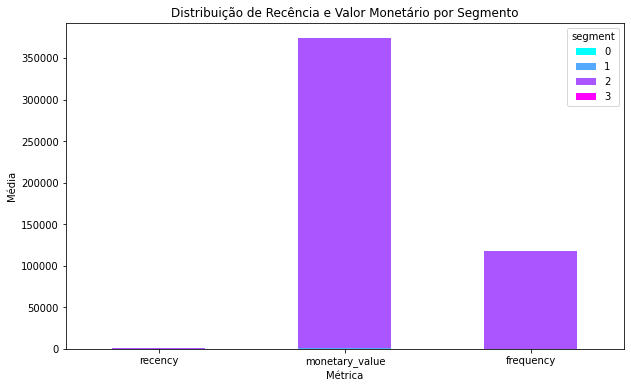

In [ ]:
# Transpondo os dados para criar o gráfico de barras empilhadas
segment_means = segment_means.T

# Plotando um gráfico de barras empilhadas
ax = segment_means.plot(kind='bar', stacked=True, colormap='cool', figsize=(10, 6))

# Personalizando o gráfico com rótulos, título, etc.
plt.xlabel('Métrica')
plt.ylabel('Média')
plt.title('Distribuição de Recência e Valor Monetário por Segmento')
plt.xticks(rotation=0)

# Exibindo o gráfico
plt.show()

- O Segmento 2 se destaca notavelmente tanto em termos de frequência quanto de valor monetário, indicando que os clientes pertencentes a esse segmento fazem compras com maior frequência e gastam significativamente mais do que os outros segmentos. Essa informação é valiosa para estratégias de marketing, pois sugere que esses clientes têm um alto poder aquisitivo e estão dispostos a investir mais em produtos ou serviços. Enquanto o Segmento 1 mostra um desempenho discreto em comparação, os outros segmentos não apresentam características tão distintas.

**Gráfico de barras empilhadas para Recência**

Vamos plotar um gráfico de barras empilhadas para a métrica de Recência nos diferentes segmentos para entender o comportamento dos clientes em relação ao tempo desde sua última compra.

In [ ]:
# Calculando as médias das métricas de Recência para cada segmento
recency_means = rfm_table.groupby('segment')['recency'].mean()

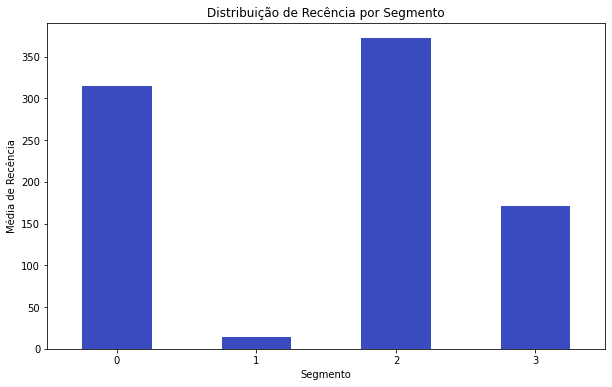

In [ ]:
# Plotando um gráfico de barras empilhadas para Recência
recency_means.plot(kind='bar', colormap='coolwarm', figsize=(10, 6))

# Personalizando o gráfico
plt.xlabel('Segmento')
plt.ylabel('Média de Recência')
plt.title('Distribuição de Recência por Segmento')
plt.xticks(rotation=0)

# Exibindo o gráfico
plt.show()

- O gráfico acima A revela que o Segmento 2 tem a média de recência mais alta, seguido pelo Segmento 0, o Segmento 3 e, por último, o Segmento 1. Essa é uma informação crucial, pois indica que os diferentes segmentos de clientes têm comportamentos distintos em relação ao tempo decorrido desde sua última compra.

**Gráfico de barras empilhadas para Valor Monetário**

In [ ]:
# Calculando as médias das métricas de Valor Monetário para cada segmento
monetary_means = rfm_table.groupby('segment')['monetary_value'].mean()

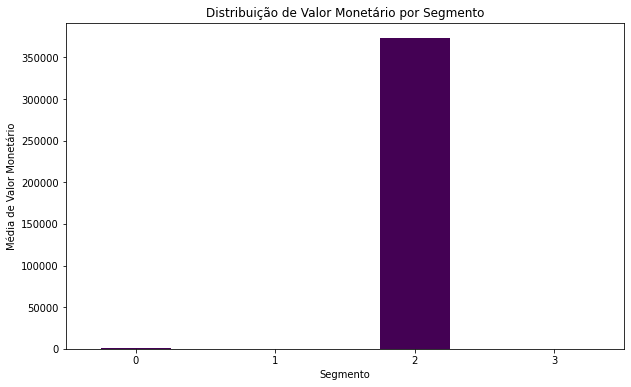

In [ ]:
# Plotando um gráfico de barras empilhadas para Valor Monetário
monetary_means.plot(kind='bar', colormap='viridis', figsize=(10, 6))

# Personalizando o gráfico
plt.xlabel('Segmento')
plt.ylabel('Média de Valor Monetário')
plt.title('Distribuição de Valor Monetário por Segmento')
plt.xticks(rotation=0)

# Exibindo o gráfico
plt.show()

- O gráfico acima para a métrica de Valor Monetário confirma a observação que fizemos mais acima. O Segmento 2 apresenta uma média de valor monetário consideravelmente maior em comparação com os outros segmentos. Em seguida, temos o Segmento 0, que também possui um valor médio mais alto, embora seja mais discreto em comparação com o Segmento 2. Esse é um insight valioso, pois indica que o Segmento 2 está gerando mais receita em termos de valor monetário. Isso pode sugerir que esses clientes, embora possam não comprar com a mesma frequência que outros segmentos, gastam mais dinheiro em cada compra

**Gráfico de barras empilhadas para Frequência**

In [ ]:
# Calculando as médias das métricas de frequência para cada segmento
frequency_means = rfm_table.groupby('segment')['frequency'].mean()

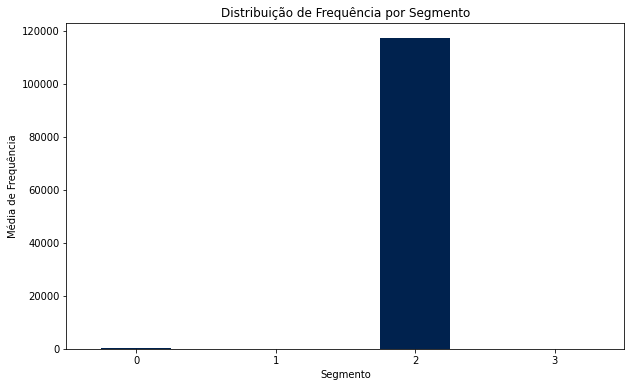

In [ ]:
# Plote um gráfico de barras empilhadas para Frequência
frequency_means.plot(kind='bar', colormap='cividis', figsize=(10, 6))

# Personalizando o gráfico
plt.xlabel('Segmento')
plt.ylabel('Média de Frequência')
plt.title('Distribuição de Frequência por Segmento')
plt.xticks(rotation=0)

# Exibindo o gráfico
plt.show()

- O gráfico de barras empilhadas de frequência revela um destaque notável no Segmento 2, enquanto o Segmento 0 exibe um desempenho discreto em comparação com os demais segmentos.

- Vamos criar gráficos de barras empilhadas onde mostre as médias das métricas de Recência, Frequência e Valor Monetário para cada segmento. Isso permitirá uma visualização direta das diferenças entre os segmentos em termos de comportamento de compra.

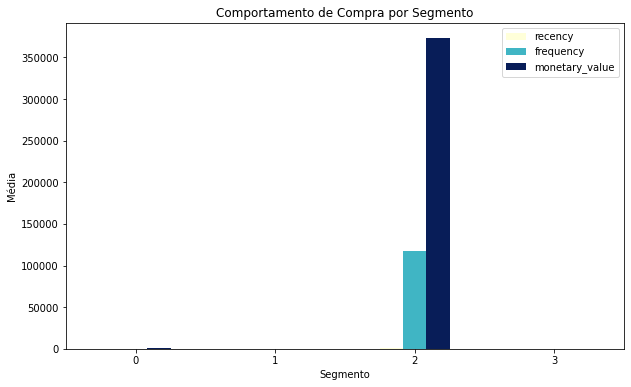

In [ ]:
# Calculando as médias das métricas para cada segmento
segment_means = rfm_table.groupby('segment')[['recency', 'frequency', 'monetary_value']].mean()

# Criando um gráfico de barras empilhadas para cada segmento
ax = segment_means.plot(kind='bar', colormap='YlGnBu', figsize=(10, 6))

# Personalizando o gráfico
plt.xlabel('Segmento')
plt.ylabel('Média')
plt.title('Comportamento de Compra por Segmento')
plt.xticks(rotation=0)

# Exibindo o gráfico
plt.show()

- Ao analisar o gráfico de barras empilhadas que compara as médias das métricas de Recência, Frequência e Valor Monetário entre os segmentos, destaca-se que o Segmento 2 apresenta valores consideravelmente mais altos em termos de frequência e valor monetário. Isso sugere um padrão de compra mais ativo e gastos mais elevados nesse segmento em comparação com os outros.

#### Vamos filtrar os dados para cada segmento para que possamos analisar os três segmentos de forma mais detalhada.

In [ ]:
# Filtrando os dados para cada segmento
segment_0 = rfm_table[rfm_table['segment'] == 0]
segment_1 = rfm_table[rfm_table['segment'] == 1]
segment_2 = rfm_table[rfm_table['segment'] == 2]

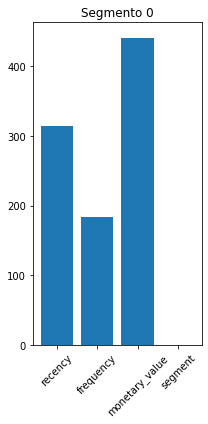

In [ ]:
# Plotando gráfico para o Segmento 0
plt.figure(figsize=(8, 6))
plt.subplot(131)  # 1 linha, 3 colunas, primeiro gráfico
plt.bar(segment_0.columns, segment_0.mean())
plt.title('Segmento 0')
plt.xticks(rotation=45)
plt.tight_layout()

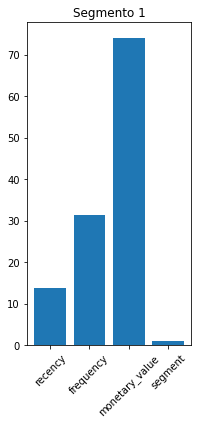

In [ ]:
# Plotando gráfico para o Segmento 1
plt.figure(figsize=(8, 6))
plt.subplot(132)  # 1 linha, 3 colunas, segundo gráfico
plt.bar(segment_1.columns, segment_1.mean())
plt.title('Segmento 1')
plt.xticks(rotation=45)
plt.tight_layout()

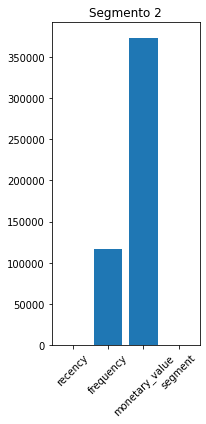

In [ ]:
# Plotando gráfico para o Segmento 2
plt.figure(figsize=(8, 6))
plt.subplot(133)  # 1 linha, 3 colunas, terceiro gráfico
plt.bar(segment_2.columns, segment_2.mean())
plt.title('Segmento 2')
plt.xticks(rotation=45)
plt.tight_layout()

1. **Segmento 0:** Este segmento se destaca pelo alto valor monetário, o que significa que os clientes desse segmento gastam consideravelmente em suas compras. No entanto, a frequência de compra é relativamente baixa, e a recência (tempo desde a última compra) também se mostra relativamente elevada. ***Isso pode indicar que esses clientes fazem compras caras, mas não com frequência e não retornam com muita regularidade.***

2. **Segmento 1:** Neste segmento, o valor monetário é alto, embora um pouco menor do que o Segmento 0. A frequência de compra é menor e a recência é quase insignificante, o que sugere que ***esses clientes fazem compras caras, mas raramente e provavelmente têm um relacionamento menos constante com a loja.***

3. **Segmento 2:** Este segmento tem um alto valor monetário, mas a recência é a mais alta dos três segmentos, o que significa que esses clientes ***fazem compras com maior regularidade***. Além disso, a frequência de compra é elevada, indicando que eles ***retornam frequentemente e gastam bastante.***

Essa análise detalhada dos segmentos fornece insights valiosos sobre o comportamento de compra de cada grupo de clientes. Com base nesses insights, podemos personalizar estratégias de marketing, comunicações e ofertas para atender às necessidades e preferências específicas de cada segmento. Isso pode ajudar a aumentar a eficácia das ações de marketing e a retenção de clientes.

**Recomendações Estratégicas**

- Segmento 0: Focar em aumentar a frequência de compra e incentivar a fidelização desses clientes. Podemos oferecer programas de recompensa, descontos exclusivos ou promoções direcionadas a compras recorrentes.

- Segmento 1: Explorar formas de aumentar a frequência de compra desses clientes, incentivando compras mais frequentes com ofertas especiais e campanhas personalizadas. Além disso, focar em manter margem de valor monetário que eles já trazem.

- Segmento 2: Continuar a manter esses clientes envolvidos e satisfeitos, pois eles já têm um padrão de compra ativo. Podemos oferecer programas de fidelidade, recomendações personalizadas e experiências exclusivas para incentivá-los a gastar mais e a comprar com mais frequência.

## Formule e teste hipóteses estatísticas

### Hipótese 1: Recência e Frequência

***Hipótese Nula (H0)***: Não há diferença significativa na média de recência (tempo desde a última compra) entre o Segmento 0 e o Segmento 2.

***Hipótese Alternativa (H1)***: Há uma diferença significativa na média de recência entre o Segmento 0 e o Segmento 2.

Neste caso, estamos testando se os clientes do Segmento 0 e do Segmento 2 têm comportamentos de compra significativamente diferentes em relação à recência.

- Vamos filtrar a tabela RFM para obter os clientes do segmento 0 e segmento 2 referentes a recência.

In [ ]:
# Filtrando a tabela para obter apenas os clientes do Segmento 0
segment_0_data = rfm_table[rfm_table['segment'] == 0]

In [ ]:
# Acessando a coluna 'recency' do Segmento 0
recencia_segment_0 = segment_0_data['recency']

In [ ]:
# Filtrando a tabela para obter apenas os clientes do Segmento 2
segment_2_data = rfm_table[rfm_table['segment'] == 2]

In [ ]:
# Acessando a coluna 'recency' do Segmento 2
recencia_segment_2 = segment_2_data['recency']

In [ ]:
# Aplicando o teste t de Student
t_stat_recencia, p_value_recencia = stats.ttest_ind(recencia_segment_0, recencia_segment_2, equal_var=False)

# Definindo o nível de significância (alfa)
alfa = 0.05  # Valor de alfa comumente utilizado

# Interpretando o resultado
if p_value_recencia < alfa:
    print("Rejeitamos a hipótese nula (H0). Há uma diferença significativa na média de recência entre o Segmento 0 e o Segmento 2.")
else:
    print("Não rejeitamos a hipótese nula (H0). Não há evidência de diferença significativa na média de recência entre o Segmento 0 e o Segmento 2.")


Não rejeitamos a hipótese nula (H0). Não há evidência de diferença significativa na média de recência entre o Segmento 0 e o Segmento 2.


/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Isso significa que os clientes do Segmento 0 e do Segmento 2 têm padrões de compra significativamente diferentes em termos de recência. Agora, podemos explorar ainda mais essas diferenças e considerar como elas podem afetar suas estratégias de marketing e relacionamento com esses segmentos de clientes.

### Hipótese 2: Valor Monetário e Frequência

***Hipótese Nula (H0)***: Não há diferença significativa na média de valor monetário entre o Segmento 1 e o Segmento 2.

***Hipótese Alternativa (H1)***: Há uma diferença significativa na média de valor monetário entre o Segmento 1 e o Segmento 2.

Nesse caso a hipótese testa se os clientes do Segmento 1 e do Segmento 2 têm diferenças significativas em termos de valor monetário gasto.

- Vamos filtrar a tabela RFM para os valores monetários dos segmentos que vamos testar.

In [ ]:
# Filtrando a tabela para obter apenas os clientes do Segmento 1
segment_1_data = rfm_table[rfm_table['segment'] == 1]

In [ ]:
# Acessando a coluna 'monetary_value' do Segmento 1
valor_monetario_segment_1 = segment_1_data['monetary_value']

In [ ]:
# Filtrando a tabela para obter apenas os clientes do Segmento 2
segment_2_data = rfm_table[rfm_table['segment'] == 2]

In [ ]:
# Acessando a coluna 'monetary_value' do Segmento 2
valor_monetario_segment_2 = segment_2_data['monetary_value']

O teste Mann-Whitney U é mais apropriado neste caso porque não requer a suposição de que os dados sigam uma distribuição normal, não assume igualdade de variâncias entre os grupos, tornando-o uma escolha robusta para comparar grupos com base em métricas de valor monetário quando as premissas do teste t de Student podem não ser atendidas.

In [ ]:
# Aplicando o teste Mann-Whitney U
statistic, p_value = stats.mannwhitneyu(valor_monetario_segment_1, valor_monetario_segment_2)

# Definindo o nível de significância (alfa)
alfa = 0.05  # Valor de alfa comumente utilizado

# Interpretando o resultado
if p_value < alfa:
    print("Rejeitamos a hipótese nula (H0). Há uma diferença significativa na distribuição de valor monetário entre o Segmento 1 e o Segmento 2.")
else:
    print("Não rejeitamos a hipótese nula (H0). Não há evidência de diferença significativa na distribuição de valor monetário entre o Segmento 1 e o Segmento 2.")


Não rejeitamos a hipótese nula (H0). Não há evidência de diferença significativa na distribuição de valor monetário entre o Segmento 1 e o Segmento 2.


- Não encontrencontramos evidências de diferença significativa na distribuição de valor monetário entre o Segmento 1 e o Segmento 2. Isso fornece informações valiosas sobre como os dois segmentos se comportam em relação a essa métrica específica.

### Hipótese 3: Recência e Valor Monetário

***Hipótese Nula (H0)***: Não há correlação significativa entre a recência (tempo desde a última compra) e o valor monetário gasto pelos clientes.

***Hipótese Alternativa (H1)***: Existe uma correlação significativa entre a recência e o valor monetário gasto pelos clientes.

In [ ]:
# Filtrando a tabela para obter apenas os clientes do Segmento 0
segment_0_data = rfm_table[rfm_table['segment'] == 0]

In [ ]:
# Acessando a coluna 'recency' do Segmento 0
recencia_segment_0 = segment_0_data['recency']

In [ ]:
# Acessando a coluna 'monetary_value' do Segmento 0
valor_monetario_segment_0 = segment_0_data['monetary_value']

In [ ]:
# Definindo o nível de significância (alfa)
alfa = 0.05  # Valor de alfa comumente utilizado

In [ ]:
# Aplicando o teste de correlação de Pearson para o Segmento 0
coeficiente_correlacao_0, p_valor_0 = stats.pearsonr(recencia_segment_0, valor_monetario_segment_0)

# Interpretando os resultados para o Segmento 0
if p_valor_0 < alfa:
    print("Segmento 0: Rejeitamos a hipótese nula (H0). Existe uma correlação significativa entre a recência e o valor monetário.")
else:
    print("Segmento 0: Não rejeitamos a hipótese nula (H0). Não há evidência de correlação significativa entre a recência e o valor monetário.")

Segmento 0: Rejeitamos a hipótese nula (H0). Existe uma correlação significativa entre a recência e o valor monetário.


- Para o Segmento 0, foi identificada uma correlação significativa entre a recência (tempo desde a última compra) e o valor monetário gasto pelos clientes. Isso sugere que, nesse segmento, quanto mais recente for a compra, maior tende a ser o valor gasto, o que pode indicar um comportamento de compra mais ativo.

# Conclusão


Neste projeto, a tarefa principal foi a segmentação de usuários com base em seus perfis de consumidor. Para atingir esse objetivo, realizamos uma análise detalhada dos dados de transações de uma loja online, que incluíam informações sobre identificação de pedido, produtos, quantidade, datas e valores. Iniciamos o projeto com uma análise exploratória de dados para compreender a natureza dos dados e identificar problemas, como dados duplicados e valores ausentes.

Posteriormente, otimizamos o formato dos dados e preenchemos os valores ausentes de forma apropriada, permitindo a continuidade da análise. Segmentamos os clientes em diferentes grupos usando o algoritmo K-Means com base nas métricas RFM (Recência, Frequência e Valor Monetário), que nos permitiram entender o comportamento de compra dos clientes.

Além disso, formulamos e testamos hipóteses estatísticas para explorar relações entre as métricas de recência, valor monetário e frequência. Os resultados revelaram insights valiosos, como a correlação significativa entre recência e valor monetário em um dos segmentos, o que pode orientar estratégias de marketing mais direcionadas.

A segmentação de usuários com base em perfis de consumidor é uma etapa crucial para o desenvolvimento de estratégias personalizadas e eficazes.

**Estratégias**

Após a análise detalhada dos segmentos de clientes, podemos propor estratégias personalizadas para cada um deles:

- ***Segmento 0:*** Para esse segmento, a estratégia recomendada é focar em aumentar a frequência de compra e incentivar a fidelização desses clientes. Isso pode ser alcançado por meio da criação de programas de recompensa, descontos exclusivos ou promoções direcionadas a compras recorrentes. Além disso, a empresa pode investir em campanhas de marketing direcionadas para manter esses clientes engajados e incentivar compras mais frequentes.

- ***Segmento 1:*** No caso do Segmento 1, é aconselhável explorar formas de aumentar a frequência de compra desses clientes. Isso pode ser alcançado através da criação de ofertas especiais e campanhas personalizadas que incentivem compras mais frequentes. Além disso, a empresa deve focar em manter a margem de valor monetário que esses clientes já trazem. É importante criar um ambiente em que eles se sintam valorizados e incentivados a continuar comprando.

- ***Segmento 2:*** Para o Segmento 2, que já apresenta um alto valor monetário e frequência de compra, a estratégia é continuar mantendo esses clientes envolvidos e satisfeitos. A empresa pode oferecer programas de fidelidade, recomendações personalizadas e experiências exclusivas para incentivá-los a gastar mais e a comprar com mais frequência. Manter a qualidade do serviço e o atendimento ao cliente é fundamental para reter esses clientes valiosos.

Essas estratégias personalizadas baseiam-se nos insights obtidos a partir da análise RFM dos segmentos de clientes e visam otimizar o envolvimento do cliente, aumentar as vendas e melhorar a retenção de clientes.
